In [67]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from pandas import DataFrame

from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder
import xgboost
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

https://archive.ics.uci.edu/ml/datasets/wine+quality

In [68]:
data = pd.read_csv('winequality-red.csv', sep = ';')

1.Разделите выборку на обучающую и тестовую в отношении 70%/30%

In [69]:
y = data.quality
X = data.drop(columns='quality')

learn_df, test_df, learn_y, test_y = train_test_split(X, y, test_size=0.3)


2.Оцените качество по метрике accuracy для классификаторов:

DecisionTreeClassifier

BaggingClassifier со 100 деревьями

RandomForestClassifier со 100 деревьями

Сравните результаты и напишите какой вывод можно сделать.

In [70]:
tree_classifier_model = DecisionTreeClassifier()
tree_classifier_model.fit(learn_df, learn_y)
tree_classifier_predict = tree_classifier_model.predict(test_df)
tree_accuracy = accuracy_score(test_y, tree_classifier_predict)
print('Accuracy for DecisionTreeClassifier: ', tree_accuracy)

Accuracy for DecisionTreeClassifier:  0.61875


In [71]:
bc_with_trees = BaggingClassifier(base_estimator=tree_classifier_model, n_estimators=100)
bc_with_trees.fit(learn_df, learn_y)
bc_with_trees_predict = bc_with_trees.predict(test_df)
bc_with_trees_accuracy = accuracy_score(test_y, bc_with_trees_predict)
print('Accuracy for BaggingClassifier with 100 trees: ', bc_with_trees_accuracy)

Accuracy for BaggingClassifier with 100 trees:  0.6770833333333334


In [72]:
def get_random_forest_accuracy_with_n_trees(trees_count:int):
    random_forest_model = RandomForestClassifier(n_estimators=trees_count)
    random_forest_model.fit(learn_df, learn_y)
    random_forest_predict = random_forest_model.predict(test_df)
    random_forest_accuracy = accuracy_score(test_y, random_forest_predict)
    return random_forest_accuracy

random_forest_accuracy = get_random_forest_accuracy_with_n_trees(100)

print('Accuracy for RandomForestClassifier with n_estimators=100: ', random_forest_accuracy)

Accuracy for RandomForestClassifier with n_estimators=100:  0.675


Вывод: Bagging дает лучшие результаты, чем простое применение DecisionTreeClassifier,
однако RandomForestClassifier, использующий внутри тот же DecisionTreeClassifier дает ещё лучшие результаты

3.Посчитайте качество на тестовой выборке по метрике accuracy для классификатора RandomForestClassifier, используя значения деревьев:
    
10, 50, 100, 200, далее с шагом 200 до 5000 деревьев.
Постройте график зависимости качества от числа деревьев.



In [73]:
accuracy_by_n = DataFrame(columns=['n_trees', 'accuracy'])

for a in range(1,25):
    current_model = RandomForestClassifier(n_estimators=a*200)
    current_n = a*200
    current_accuracy = get_random_forest_accuracy_with_n_trees(current_n)
    row_df = DataFrame.from_dict({'n_trees': [current_n], 'accuracy': [current_accuracy]})
    accuracy_by_n = pd.concat([accuracy_by_n, row_df])
accuracy_by_n = accuracy_by_n.reset_index(drop=True)
accuracy_by_n = accuracy_by_n.set_index('n_trees')
accuracy_by_n.head()

/Users/max/miniforge3/envs/tensorflow/lib/python3.9/site-packages/pandas/core/indexes/base.py:6999: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  return Index(sequences[0], name=names)


,accuracy
n_trees,
200,0.672917
400,0.681250
600,0.677083
800,0.685417
1000,0.675000


<AxesSubplot:xlabel='n_trees'>

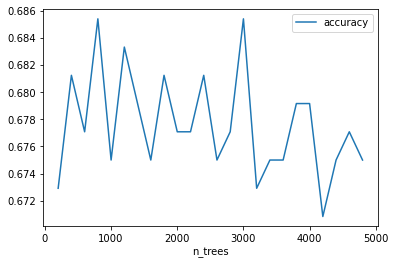

In [74]:
accuracy_by_n.plot()



4.Обучите реализации градиентного бустинга с параметрами по умолчанию из библиотек sklearn и xgboost. Сравните значение метрики accuracy по cross_val_score

In [75]:
sk_learn_gradient_boosting_model = GradientBoostingClassifier()
cross_val_score_sk_gradient_boosting = cross_val_score(sk_learn_gradient_boosting_model, learn_df, learn_y, scoring='accuracy')
print(f'Cross_val_score for gradient boosting sklearn: {cross_val_score_sk_gradient_boosting}')

print(f'xgboost library version {xgboost.__version__}')
xgboost_gradient_boosting_model = xgboost.XGBClassifier()

le = LabelEncoder()
learn_y_labeled = le.fit_transform(learn_y)
test_y_labeled = le.fit_transform(test_y)

cross_val_score_xgboost_gradient_boosting = cross_val_score(xgboost_gradient_boosting_model, learn_df, learn_y_labeled, scoring='accuracy', error_score='raise')
print(f'Cross_val_score for gradient boosting xgboost: {cross_val_score_xgboost_gradient_boosting}')

mean_sklearn = cross_val_score_sk_gradient_boosting.mean()
mean_xgboost = cross_val_score_xgboost_gradient_boosting.mean()

assert mean_xgboost > mean_sklearn

Cross_val_score for gradient boosting sklearn: [0.63839286 0.66964286 0.62053571 0.625      0.60538117]
xgboost library version 1.7.1
Cross_val_score for gradient boosting xgboost: [0.65178571 0.63392857 0.63839286 0.64285714 0.632287  ]


Вывод: реализация градиентного бустинга с параметрами по умолчанию в xgboost дает лучшие результаты по метрике accuracy по сравнению с реализацией в sklearn

5.Подберите оптимальные параметры этих алгоритмов с помощью GridSearchCV(cv=3).
Параметры для оптимизации:

скорость обучения

количество деревьев

глубина деревьев

Сравните значение метрики accuracy и скорость работы. Выведите лучшие параметры алгоритмов.

In [76]:
from sklearn.model_selection import GridSearchCV

dict_param_grid = {'learning_rate':[0.1, 0.3, 0.5, 0.7, 1, 1.5, 2,5],
'n_estimators': [1, 10, 25, 50],
'max_depth': range(1,12)}


In [77]:
%%time 

grid_sklearn = GridSearchCV(sk_learn_gradient_boosting_model, cv=3, param_grid=dict_param_grid)

grid_sklearn.fit(learn_df, learn_y)
predicted  = grid_sklearn.predict(test_df)
accuracy = accuracy_score(test_y, predicted)
print(accuracy)
print(grid_sklearn.best_params_)


0.6604166666666667
{'learning_rate': 0.3, 'max_depth': 7, 'n_estimators': 50}
CPU times: user 3min 55s, sys: 1.52 s, total: 3min 56s
Wall time: 3min 56s


In [78]:
%%time
grid_xgboost = GridSearchCV(xgboost_gradient_boosting_model, cv=3, param_grid=dict_param_grid)

grid_xgboost.fit(learn_df, learn_y_labeled)
predicted  = grid_xgboost.predict(test_df)

accuracy = accuracy_score(test_y_labeled, predicted)
print(accuracy)
print(grid_xgboost.best_params_)


0.6375
{'learning_rate': 0.3, 'max_depth': 5, 'n_estimators': 25}
CPU times: user 5min 11s, sys: 2min 46s, total: 7min 57s
Wall time: 1min 17s


6.Обучите реализации градиентного бустинга с параметрами по умолчанию из библиотек lightgbm и catboost. Сравните значение метрики accuracy по cross_val_score по всем четырем реализациям.

In [79]:
l = LGBMClassifier()
l.fit(learn_df, learn_y)
pp = l.predict(test_df)
accuracy_lg = accuracy_score(test_y, pp)
print(f'Accuracy for lightgbm: {accuracy_lg}')

Accuracy for lightgbm: 0.6583333333333333


In [80]:
cat = CatBoostClassifier()
cat.fit(learn_df, learn_y)
pp_cat = cat.predict(test_df)
accuracy_cat = accuracy_score(test_y, pp_cat)
print(f'Accuracy for catboost: {accuracy_cat}')

Learning rate set to 0.079582
0:	learn: 1.6855234	total: 3.52ms	remaining: 3.51s
1:	learn: 1.6013270	total: 5.22ms	remaining: 2.61s
2:	learn: 1.5256971	total: 7.27ms	remaining: 2.42s
3:	learn: 1.4603212	total: 9.02ms	remaining: 2.25s
4:	learn: 1.4047753	total: 10.8ms	remaining: 2.15s
5:	learn: 1.3578125	total: 12.9ms	remaining: 2.14s
6:	learn: 1.3127289	total: 15.6ms	remaining: 2.21s
7:	learn: 1.2724826	total: 17.4ms	remaining: 2.16s
8:	learn: 1.2379536	total: 19.6ms	remaining: 2.16s
9:	learn: 1.2060062	total: 21.4ms	remaining: 2.12s
10:	learn: 1.1762632	total: 22.9ms	remaining: 2.06s
11:	learn: 1.1485426	total: 24.8ms	remaining: 2.04s
12:	learn: 1.1283826	total: 26.6ms	remaining: 2.02s
13:	learn: 1.1053269	total: 29.2ms	remaining: 2.06s
14:	learn: 1.0858217	total: 30.9ms	remaining: 2.02s
15:	learn: 1.0686937	total: 32.9ms	remaining: 2.02s
16:	learn: 1.0529591	total: 34.9ms	remaining: 2.02s
17:	learn: 1.0390063	total: 36.9ms	remaining: 2.02s
18:	learn: 1.0231520	total: 38.6ms	remaining

7.Подберите оптимальные параметры для алгоритмов градиентного бустинга из библиотек lightgbm и catboost с теми же условиями. Выведите лучшие параметры алгоритмов.
Сравните значение метрики accuracy и скорость по этим четырем реализациям.

8.Подберите оптимальные параметры алгоритма из библиотеки xgbost с помощью [optuna](https://github.com/optuna/optuna) . Параметры для оптимизации:

скорость обучения

количество деревьев

глубина деревьев

Сравните результат с поиском по сетке из sklearn. Выведите лучшие параметры алгоритма, найденные даным способом.

9.Выведите качество по метрике accuracy стэкинга (StackingClassifier) 4-х алгоритмов с базовыми параметрами градиентного бустинга.

10.Выведите качество по метрике accuracy стэкинга 4-х алгоритмов с оптимальными параметрами градиентного бустинга. Сравните результаты с предыдущим шагом и напишите какой вывод можно из этого сделать.